# Community alignment of training questions

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from ollama_models import ollama_models
models = ollama_models()

In [3]:
from community_alignment import community_alignment

Loaded existing index from forecast_index.faiss
Index contains 5717 vectors at initialization


100%|████████████████████████████████████████████████████████████████████████████████| 709/709 [00:00<00:00, 32730.85it/s]


saved community_gemma3:latest.json


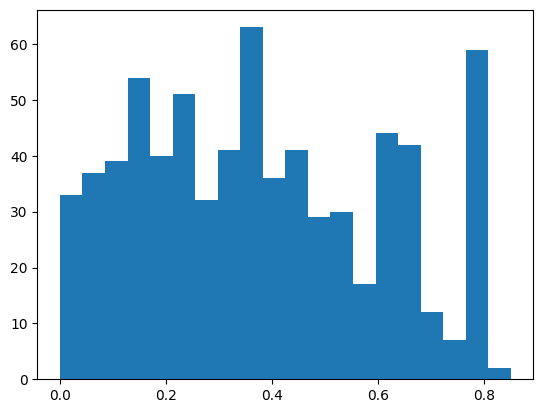

In [4]:
dfs = {}
for model in models:
    df = community_alignment(model)
    dfs[model] = df

In [5]:
for model in models:
    df = dfs[model]
    df1 = df[['model', 'id', 'title', 'error']].sort_values(by='id')
    display(df1)

,model,id,title,error
20,gemma3:latest,111,Will there be a total solar eclipse on June 25...,0.600
36,gemma3:latest,161,Will the Universe end?,0.020
89,gemma3:latest,349,Will SpaceX land people on Mars before 2030?,0.348
90,gemma3:latest,353,Will someone born before 2001 live to be 150?,0.110
98,gemma3:latest,372,Will human brain emulation be the first succes...,0.235
...,...,...,...,...
681,gemma3:latest,28570,"Will there be a global recession before 2026, ...",0.250
2,gemma3:latest,28682,Will any country trigger article 50 to leave t...,0.220
64,gemma3:latest,30959,Will the US Department of Health and Human Ser...,0.400
65,gemma3:latest,30960,"Will CDC report 10,000 or more H5 avian influe...",0.620


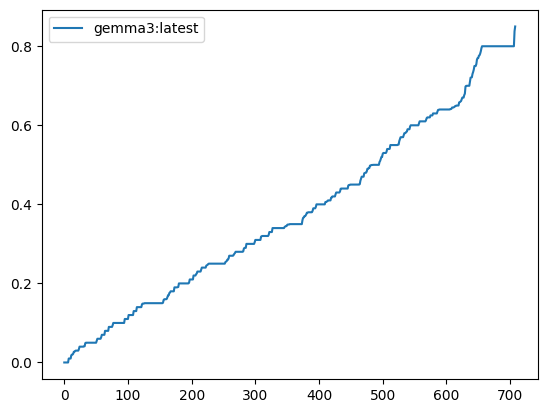

In [6]:
import matplotlib.pylab as plt
errors = []
for model in models:
    df = dfs[model]
    errors.append((model, df.error.median()))
    plt.plot(sorted(df['error'].values.tolist()), label=model)
plt.legend();

In [7]:
dfe = pd.DataFrame(errors, columns = ['model', 'medianError'])

In [8]:
dfe.sort_values(by='medianError')

,model,medianError
0,gemma3:latest,0.35


In [9]:
df1.sort_values(by='error')

,model,id,title,error
351,gemma3:latest,1059,"Before 2051, will a meteor cause more injuries...",0.000
496,gemma3:latest,1432,Will humans have a sustainable off-world prese...,0.000
482,gemma3:latest,1385,Qualia Research Institute Question Series: Wil...,0.000
492,gemma3:latest,7552,Will the Confederate monument on Stone Mountai...,0.000
15,gemma3:latest,26717,"Five years after AGI, will there be widely ava...",0.000
...,...,...,...,...
315,gemma3:latest,7079,How far away is the nearest independent origin...,0.800
244,gemma3:latest,4851,What will be the percentage of the world popul...,0.800
460,gemma3:latest,1341,Drake's Equation 5th Parameter f_i: On what fr...,0.800
567,gemma3:latest,13897,Will a government space agency commence a crew...,0.838


In [10]:
from call_local_llm import call_local_llm

In [11]:
from ollama_models import ollama_models

In [18]:
model = ollama_models()[0]

In [19]:
model

'deepseek-r1:8b-llama-distill-q4_K_M'

In [79]:
id_title = [f'{id},{title}' for id, title in df1[['id', 'title']].values]

In [80]:
id_title[0:10]

['111,Will there be a total solar eclipse on June 25, 2522?',
 '161,Will the Universe end?',
 '349,Will SpaceX land people on Mars before 2030?',
 '353,Will someone born before 2001 live to be 150?',
 '372,Will human brain emulation be the first successful route to human-level digital intelligence?',
 '375,Will any of Belgium, France, Italy, Luxembourg, Netherlands, and/or Germany leave the EU before 2027?',
 '384,Will there be Human-machine intelligence parity before 2040?',
 '397,Will RoboCup announce that robots have beaten professional human soccer players before 2050?',
 '480,If chess is solved before 2080, must perfect play result in white winning?',
 '491,Will China reduce their carbon emissions per GDP by 60% by 2030?']

In [27]:
prompt = f"""You are given a sequence of binary, numeric or multiple choice questions.
DO NOT attempt to answer these questions.
DO find a list of 10 "subject matter expert" (SME) domain descriptions that these questions fall into.
TELL ME your list of 10 SME domains.
DO NOT tell me anything else.
Here are the questions: 

{'\n'.join(df1.title.values)}"""

In [32]:
report2 = call_local_llm(prompt, model)

In [65]:
categories = [x.replace('**', '').replace(': ','').split('. ')[1].replace(':','') for x in report2.split('\n') if '**' in x]

In [180]:
with open('categories.txt', 'w') as f:
    f.write(repr(categories))

In [181]:
!cat categories.txt

['Political Predictions', 'AI Developments', 'Economic Trends', 'Health Crises', 'Military and Conflict', 'Societal Shifts', 'Technological Breakthroughs', 'Market Performance']

In [100]:
from tqdm.auto import tqdm

In [217]:
id_to_category = {}

for index, row in tqdm(df1.iterrows(), total=len(df1)):
    id = row.id
    title = row.title
    prompt = f"""For this question: {title}
    
    tell me which one of the following categories most closely matches the subject matter of the question.  
    If the question fits no category in the list, propose a new category.
    In all cases, give me the category name in form <<CATEGORYNAME>> on a new line.
    
    {'\n'.join(categories)}"""
    
    result = call_local_llm(prompt, model)
    cat = result.split('</think>')[1].strip().split('<<')[1].split('>>')[0]
    id_to_category[id] = cat

  0%|          | 0/709 [00:00<?, ?it/s]

In [220]:
with open('id_to_category.json', 'w') as f:
    json.dump(id_to_category, f, indent=4)

In [261]:
with open('id_to_category.json', 'r') as f:
    id_to_category = json.load(f)

In [262]:
  set(id_to_category.values())

{'AI Developments',
 'ASTROPHYSICAL PROBABILITY',
 'Astronomical Discoveries',
 'Astronomical Events',
 'Astronomical Phenomena',
 'Astronomical or Cosmological Studies',
 'Biology and Zoology',
 'Climate Projections',
 'Climate Science',
 'Cosmological Predictions',
 'Cryptozoological Discoveries',
 'Cultural Preservation and Interstellar Communication',
 'Cultural and Intellectual Trends',
 'Demographic Projections',
 'Demographic Shifts',
 'Demographic Trends',
 'Donor Behavior Trends',
 'ENVIRONMENTAL PREDICTIONS',
 'ENVIRONMENTAL SUSTAINABILITY',
 'Economic Trends',
 'EconomicTrends',
 'Environmental Catastrophes',
 'Environmental Changes',
 'Environmental Predictions',
 'Existential Risks',
 'Extraterrestrial Life',
 'Extraterrestrial Life and SETI Research',
 'Future Trends',
 'Global Stability',
 'Health Crises',
 'LEGAL SENTENCES',
 'Legal Consequences',
 'Legal Sentences',
 'Longevity Science',
 'MARKET PERFORMANCE',
 'Market Performance',
 'MarketPerformance',
 'Martian Biol

In [263]:
problems = [x for x,y in id_to_category.items() if y in ['NEW_CATEGORY',
 'New Category',
 'NewCategory']]

In [294]:
fixes = []
for index, row in tqdm(df1.iterrows(), total=len(df1)):
    id = row.id
    if id not in problems:
        continue
    title = row.title
    prompt = f"""For this question: {title}
    
    tell me which one of the following categories most closely matches the subject matter of the question.  
    If the question fits no category in the list, propose a new category.
    If you propose a new category, the name must be DESCRIPTIVE and not a variation on the name "New Category".
    In all cases, give me the category name in form <<CATEGORYNAME>> on a new line.
    
    {'\n'.join(categories)}"""
    
    result = call_local_llm(prompt, model)
    cat = result.split('</think>')[1].strip().split('<<')[1].split('>>')[0]
    fixes.append((id, title, cat))
    print(id, cat, title)

  0%|          | 0/709 [00:00<?, ?it/s]

3742 Climate Projections Will the average global CO₂ atmospheric concentration be less than 433.19 ppm over the 2024 to 2027 period?
6608 Cosmological Predictions Will most dark matter turn out to be primordial black holes?
7079 Extraterrestrial Life How far away is the nearest independent origination of life?
7790 CLIMATE PROJECTIONS Will New York City experience a hurricane before 2030?
9570 Climate Projections Longbets series: will the annual average temperature anomaly above the 1850-1899 baseline be 2.0C or higher by 2037?
20172 GOVERNANCE_STRUCTURE_CHANGES Before 2026, will OpenAI's commercial operations cease to be governed by its nonprofit board of directors?


In [265]:
categories = set([y for x,y in id_to_category.items()])

In [296]:
fixes2 = [(x, z.title(), y) for x,y,z in fixes]
fixes2    

[(3742,
  'Climate Projections',
  'Will the average global CO₂ atmospheric concentration be less than 433.19 ppm over the 2024 to 2027 period?'),
 (6608,
  'Cosmological Predictions',
  'Will most dark matter turn out to be primordial black holes?'),
 (7079,
  'Extraterrestrial Life',
  'How far away is the nearest independent origination of life?'),
 (7790,
  'Climate Projections',
  'Will New York City experience a hurricane before 2030?'),
 (9570,
  'Climate Projections',
  'Longbets series: will the annual average temperature anomaly above the 1850-1899 baseline be 2.0C or higher by 2037?'),
 (20172,
  'Governance_Structure_Changes',
  "Before 2026, will OpenAI's commercial operations cease to be governed by its nonprofit board of directors?")]

In [244]:
prompt = f"""Make a coherent, reasonably compact and complete set of new categories for each of the following old categories.
Category names should be in .title() format.
Result should be a Python dictionary that goes from old category name to new one.
EVERY SINGLE old category must be represented.
Here are the old categories:

{repr(categories)}"""

In [245]:
remap = call_local_llm(prompt, model)

In [249]:
remap = remap.split("```python")[1]

In [255]:
remap = remap.split('```')[0]

In [257]:
remap = eval(remap)

In [274]:
cats2 = set([y for x,y in remap.items()])

In [276]:
remap['Societal Shifts'] = 'Social Shifts'

In [278]:
for x in cats2:
    remap[x] = x

In [286]:
remap['NewCategory'] = 'DK'
remap['NEW_CATEGORY'] = 'DK'
remap['DK'] = 'DK'
remap['New Category'] = 'DK'

In [287]:
for id in id_to_category:
    id_to_category[id] = remap[id_to_category[id]]

In [ ]:
id_to_category

In [289]:
id_to_category1 = {int(x): y for x,y in id_to_category.items()}

In [290]:
id_to_category1

{111: 'Astrophysical Events',
 161: 'Cosmological Predictions',
 349: 'Tech Innovation',
 353: 'Global Health Risks',
 372: 'Artificial Intelligence Breakthroughs',
 375: 'Political Trends',
 384: 'Artificial Intelligence Breakthroughs',
 397: 'Artificial Intelligence Breakthroughs',
 480: 'Artificial Intelligence Breakthroughs',
 491: 'Economic Forecasting',
 492: 'Conflict Analysis',
 578: 'Existential Risk Analysis',
 585: 'Climate Science Predictions',
 594: 'Tech Innovation',
 604: 'Tech Innovation',
 605: 'Climate Science Predictions',
 606: 'Tech Innovation',
 610: 'Conflict Analysis',
 614: 'Social Shifts',
 658: 'Social Shifts',
 665: 'Global Health Risks',
 686: 'Tech Innovation',
 736: 'Economic Forecasting',
 737: 'Tech Innovation',
 797: 'Political Trends',
 808: 'Tech Innovation',
 824: 'Tech Innovation',
 841: 'Market Analytics',
 899: 'Economic Forecasting',
 915: 'Tech Innovation',
 917: 'Tech Innovation',
 980: 'Market Analytics',
 1002: 'Tech Innovation',
 1052: 'Soc

In [291]:
problems = [id for id, cat in id_to_category1.items() if cat == 'DK']

In [292]:
problems

[3742, 6608, 7079, 7790, 9570, 20172]

In [299]:
for id, cat, title in fixes:
    id_to_category1[id] = cat

In [303]:
problems2 = [(x,y) for x,y in id_to_category1.items() if 'will ' in y.lower() or 'how ' in y.lower()]

In [304]:
problems2

[(3742,
  'Will the average global CO₂ atmospheric concentration be less than 433.19 ppm over the 2024 to 2027 period?'),
 (6608, 'Will most dark matter turn out to be primordial black holes?'),
 (7079, 'How far away is the nearest independent origination of life?'),
 (7790, 'Will New York City experience a hurricane before 2030?'),
 (9570,
  'Longbets series: will the annual average temperature anomaly above the 1850-1899 baseline be 2.0C or higher by 2037?'),
 (20172,
  "Before 2026, will OpenAI's commercial operations cease to be governed by its nonprofit board of directors?")]

In [305]:
categories = list(id_to_category1.values())

In [306]:
fixes2 = []

for id, title in problems2:
    prompt = f"""For this question: {title}
    
    tell me which one of the following categories most closely matches the subject matter of the question.  
    If the question fits no category in the list, propose a new category.
    In all cases, give me the category name in form <<CATEGORYNAME>> on a new line.
    
    {'\n'.join(categories)}"""
    
    result = call_local_llm(prompt, model)
    cat = result.split('</think>')[1].strip().split('<<')[1].split('>>')[0]
    fix = (id, cat, title)
    fixes2.append(fix)
    print(fix)

(3742, 'Climate Science Predictions', 'Will the average global CO₂ atmospheric concentration be less than 433.19 ppm over the 2024 to 2027 period?')
(6608, 'Astrophysical and Cosmological Studies', 'Will most dark matter turn out to be primordial black holes?')
(7079, 'Extraterrestrial Life and SETI Research', 'How far away is the nearest independent origination of life?')
(7790, 'Climate Science Predictions', 'Will New York City experience a hurricane before 2030?')
(9570, 'CLIMATE SCIENCE PREDICTIONS', 'Longbets series: will the annual average temperature anomaly above the 1850-1899 baseline be 2.0C or higher by 2037?')
(20172, 'Tech Innovation', "Before 2026, will OpenAI's commercial operations cease to be governed by its nonprofit board of directors?")


In [309]:
for id, cat, _ in fixes2:
    id_to_category1[id] = cat.title()

In [ ]:
id_to_category1

In [311]:
cats2 = {cat: 0 for id,cat in id_to_category1.items()}

In [312]:
with open('id_to_category.json', 'w') as f:
    json.dump(id_to_category1, f, indent=4)

In [313]:
cats2 = {cat: 0 for id,cat in id_to_category1.items()}
for id,cat in id_to_category1.items():
    cats2[cat] += 1

In [314]:
cats2

{'Astrophysical Events': 3,
 'Cosmological Predictions': 1,
 'Tech Innovation': 145,
 'Global Health Risks': 37,
 'Artificial Intelligence Breakthroughs': 75,
 'Political Trends': 134,
 'Economic Forecasting': 66,
 'Conflict Analysis': 92,
 'Existential Risk Analysis': 1,
 'Climate Science Predictions': 5,
 'Social Shifts': 52,
 'Market Analytics': 44,
 'Resource Scarcity and Sustainability': 1,
 'Astrophysical and Cosmological Studies': 1,
 'Scientific Breakthroughs': 2,
 'Astronomical Findings': 1,
 'Astrophysical Probability Studies': 1,
 'Extraterrestrial Life and SETI Research': 2,
 'Medical Innovations': 1,
 'Theoretical Computing Innovations': 1,
 'Cultural Preservation and Communication': 1,
 'Population Trends': 2,
 'Environmental Disasters': 1,
 'Neuroscience Research': 1,
 'Climate Science': 1,
 'Biological Research': 1,
 'Environmental Predictions': 2,
 'Scientific Theory Development': 2,
 'Scientific Progress': 1,
 'Environmental Sustainability and Climate Science': 1,
 'E

In [318]:
df = pd.DataFrame(list(cats2.items()), columns=['category', 'count'])

In [320]:
df = df.sort_values(by='category')

In [323]:
df1 = df.reset_index(drop=True)

['Artificial Intelligence Breakthroughs',
 'Astronomical Findings',
 'Astrophysical And Cosmological Studies',
 'Astrophysical Events',
 'Astrophysical Phenomena',
 'Astrophysical Probability Studies',
 'Astrophysical and Cosmological Studies',
 'Biological Research',
 'Climate Science',
 'Climate Science Predictions',
 'Conflict Analysis',
 'Cosmological Predictions',
 'Cryptozoology Discoveries',
 'Cultural Preservation and Communication',
 'Cultural Trends and Intellectual Shifts',
 'Demographic Growth',
 'Demographic Projections',
 'Disaster Risk Assessment',
 'Economic Forecasting',
 'Economic Trends Analysis',
 'Environmental Disasters',
 'Environmental Predictions',
 'Environmental Sustainability and Climate Science',
 'Environmental Transformations',
 'Existential Risk Analysis',
 'Extraterrestrial Life And Seti Research',
 'Extraterrestrial Life and SETI Research',
 'Foresight Analysis',
 'Global Health Risks',
 'Global Security',
 'Legal Implications',
 'Legal Sentencing Tren

In [328]:
prompt = f"""Create a Python dictionary which maps these 56 categories down to 15 categories.  
The dictionary should map the 56 old category names to the 15 new category names.  Here are the categories:

{repr(df1.category.values.tolist())}"""
rpt = call_local_llm(prompt, model)

In [336]:
code = rpt.split('```python')[1].split('```')[0].strip()

In [338]:
exec(code)

In [342]:
category_mapping['Extraterrestrial Life And Seti Research'] = 'Extraterrestrial Life'

In [343]:
category_mapping

{'Artificial Intelligence Breakthroughs': 'Technology Innovation',
 'Astronomical Findings': 'Space Exploration',
 'Astrophysical And Cosmological Studies': 'Cosmology and Astronomy',
 'Astrophysical Events': 'Space Phenomena',
 'Astrophysical Phenomena': 'Space Phenomena',
 'Astrophysical Probability Studies': 'Astronomical Research',
 'Astrophysical and Cosmological Studies': 'Cosmology and Astronomy',
 'Biological Research': 'Biology and Life Sciences',
 'Climate Science': 'Environmental Science',
 'Climate Science Predictions': 'Environmental Predictions',
 'Conflict Analysis': 'Global Security',
 'Cosmological Predictions': 'Cosmology and Astronomy',
 'Cryptozoology Discoveries': 'Extraterrestrial Life',
 'Cultural Preservation and Communication': 'Cultural Trends',
 'Cultural Trends and Intellectual Shifts': 'Cultural Trends',
 'Demographic Growth': 'Population Trends',
 'Demographic Projections': 'Population Trends',
 'Disaster Risk Assessment': 'Environmental Disasters',
 'Econ

In [344]:
id_to_category2 = {x: category_mapping[y] for x,y in id_to_category1.items()}

In [345]:
id_to_category2 

{111: 'Space Phenomena',
 161: 'Cosmology and Astronomy',
 349: 'Technology Innovation',
 353: 'Public Health',
 372: 'Technology Innovation',
 375: 'Global Security',
 384: 'Technology Innovation',
 397: 'Technology Innovation',
 480: 'Technology Innovation',
 491: 'Economic Trends',
 492: 'Global Security',
 578: 'Risk Assessment',
 585: 'Environmental Predictions',
 594: 'Technology Innovation',
 604: 'Technology Innovation',
 605: 'Environmental Predictions',
 606: 'Technology Innovation',
 610: 'Global Security',
 614: 'Cultural Trends',
 658: 'Cultural Trends',
 665: 'Public Health',
 686: 'Technology Innovation',
 736: 'Economic Trends',
 737: 'Technology Innovation',
 797: 'Global Security',
 808: 'Technology Innovation',
 824: 'Technology Innovation',
 841: 'Economic Trends',
 899: 'Economic Trends',
 915: 'Technology Innovation',
 917: 'Technology Innovation',
 980: 'Economic Trends',
 1002: 'Technology Innovation',
 1052: 'Cultural Trends',
 1056: 'Technology Innovation',
 1

In [346]:
with open('id_to_category.json', 'w') as f:
    json.dump(id_to_category2, f, indent=4)

In [347]:
cats2 = {cat: 0 for id,cat in id_to_category2.items()}
for id,cat in id_to_category2.items():
    cats2[cat] += 1

In [348]:
cats2

{'Space Phenomena': 4,
 'Cosmology and Astronomy': 3,
 'Technology Innovation': 222,
 'Public Health': 37,
 'Global Security': 227,
 'Economic Trends': 113,
 'Risk Assessment': 2,
 'Environmental Predictions': 5,
 'Cultural Trends': 57,
 'Environmental Science': 6,
 'Scientific Progress': 6,
 'Space Exploration': 3,
 'Astronomical Research': 1,
 'Extraterrestrial Life': 4,
 'Healthcare Innovation': 1,
 'Demographic Growth': 3,
 'Environmental Disasters': 2,
 'Biology and Life Sciences': 2,
 'Population Trends': 4,
 'Legal and Ethical Issues': 3,
 'Sports and Recreation': 3,
 'Biological Research': 1}

In [349]:
df = pd.DataFrame(list(cats2.items()), columns=['category', 'count'])

In [354]:
df = df.sort_values(by='count', ascending=False)

In [355]:
df

,category,count
4,Global Security,227
2,Technology Innovation,222
5,Economic Trends,113
8,Cultural Trends,57
3,Public Health,37
10,Scientific Progress,6
9,Environmental Science,6
7,Environmental Predictions,5
13,Extraterrestrial Life,4
0,Space Phenomena,4
